In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.stats import spearmanr

from petTOAD_load import *
from petTOAD_parameter_setup import *
from petTOAD_analyses_helpers import *

In [3]:
A_DIR = SIM_DIR / f"a-weight_ws_{ws_min_a}-{ws_max_a}_bs_{bs_min_a}-{bs_max_a}"
A_RAND_DIR = SIM_DIR / f"a-weight_ws_{ws_min_a}-{ws_max_a}_bs_{bs_min_a}-{bs_max_a}_random"
G_DIR = SIM_DIR / f"G-weight_ws_{ws_min_G}-{ws_max_G}_bs_{bs_min_G}-{bs_max_G}"
G_RAND_DIR = SIM_DIR / f"G-weight_ws_{ws_min_G}-{ws_max_G}_bs_{bs_min_G}-{bs_max_G}_random"
SC_DIR = SIM_DIR / f"sc_disconn_ws_{ws_min_disconn}-{ws_max_disconn}_bs_0"
SC_RAND_DIR = SIM_DIR / f"sc_disconn_ws_{ws_min_disconn}-{ws_max_disconn}_bs_0_random"
HET_DIR = SIM_DIR / f"heterogeneous_ws_{ws_min_het}-{ws_max_het}_bs_{bs_min_het}-{bs_max_het}"
HET_RAND_DIR = SIM_DIR / f"heterogeneous_ws_{ws_min_het}-{ws_max_het}_bs_{bs_min_het}-{bs_max_het}_random"

In [44]:
def load_model_results(folder, model_type, is_random=False):
    
    df_res_model_all = pd.DataFrame()
    
    for item in folder.iterdir():
        if item.is_file and item.name.endswith(".csv"):
            df_res_model_subj = pd.read_csv(item, index_col = 0)
            df_res_model_subj["PTID"] = item.name.split("_")[0].split("-")[1]
            df_res_model_all = pd.concat([df_res_model_all, df_res_model_subj])

    df_res_model_all["model_type"] = model_type
    if not is_random:
        df_res_model_all["random"] = "not_random"
    else:
        df_res_model_all["random"] = "random"
    
    return df_res_model_all

def select_best_model_group(subjs_in_group, df_res_model_all, model_type):

    df_res_model_group = df_res_model_all[df_res_model_all["PTID"].isin(subjs_in_group)]

    list_models_different = ["disconnectivity", "disconnectivity_random", "baseline"]
    if model_type not in list_models_different:
        grouped = df_res_model_group.groupby(['b', 'w'])['phfcd_ks'].mean().reset_index()
        best_combination = grouped.loc[grouped['phfcd_ks'].idxmin()]
        best_b = best_combination['b']
        best_w = best_combination['w']
        df_best = df_res_model_group[(df_res_model_group["b"] == best_b) & (df_res_model_group["w"] == best_w)].copy()
    
    elif "disconnectivity" in model_type:
        grouped = df_res_model_group.groupby('w')['phfcd_ks'].mean().reset_index()
        best_combination = grouped.loc[grouped['phfcd_ks'].idxmin()]
        best_w = best_combination['w']
        df_best = df_res_model_group[df_res_model_group["w"] == best_w].copy()
    
    elif "baseline" in model_type:
        df_best = df_res_model_group[(df_res_model_group["b"] == 0) & (df_res_model_group["w"] == 0)].copy()
        df_best["model_type"] = "baseline"
        
    df_best[f"phfcd_ks_{model_type}"] = df_best["phfcd_ks"]
    
    return df_best.drop(columns=f"phfcd_ks_{model_type}"), df_best.loc[:, ["PTID", f"phfcd_ks_{model_type}"]]

def get_best_model_df_group(subjs_in_group):
    # Load all non random model results, hardcoded because they are always the same folder and dir
    df_a_all = load_model_results(A_DIR, "homogeneous_a")
    df_G_all = load_model_results(G_DIR, "homogeneous_G")
    df_het_all = load_model_results(HET_DIR, "heterogeneous")
    df_disconn_all = load_model_results(SC_DIR, "disconnectivity")
    #Select the best model for each group
    df_a, df_a_short = select_best_model_group(subjs_in_group, df_a_all, "homogeneous_a")
    df_G, df_G_short = select_best_model_group(subjs_in_group, df_G_all, "homogeneous_G")
    df_het, df_het_short = select_best_model_group(subjs_in_group, df_het_all, "heterogeneous")
    df_disconn, df_disconn_short = select_best_model_group(subjs_in_group, df_disconn_all, "disconnectivity")
    df_base, df_base_short = select_best_model_group(subjs_in_group, df_G_all, "baseline")
    
    list_dfs = [df_base, df_a, df_G, df_het, df_disconn]
    list_dfs_short = [df_base_short, df_a_short, df_G_short, df_het_short, df_disconn_short]

    return list_dfs, list_dfs_short

def get_best_model_df_random_group(subjs_in_group):
    
    # Load results from random models, hardcoded because they are always the same folder and dir
    df_a_rand_all = load_model_results(A_RAND_DIR, "homogeneous_a", is_random=True)
    df_G_rand_all = load_model_results(G_RAND_DIR, "homogeneous_G", is_random=True)
    df_het_rand_all = load_model_results(HET_RAND_DIR, "heterogeneous", is_random=True)
    df_disconn_rand_all = load_model_results(SC_RAND_DIR, "disconnectivity", is_random=True)
    
    # Load results from non-random models, hardcoded because they are always the same folder and dir
    df_a_all = load_model_results(A_DIR, "homogeneous_a")
    df_G_all = load_model_results(G_DIR, "homogeneous_G")
    df_het_all = load_model_results(HET_DIR, "heterogeneous")
    df_disconn_all = load_model_results(SC_DIR, "disconnectivity")

    #Select the best model weight and bias for each non-random model
    df_a, _ = select_best_model_group(subjs_in_group, df_a_all, "homogeneous_a")
    df_G, _ = select_best_model_group(subjs_in_group, df_G_all, "homogeneous_G")
    df_het, _ = select_best_model_group(subjs_in_group, df_het_all, "heterogeneous")
    df_disconn, _ = select_best_model_group(subjs_in_group, df_disconn_all, "disconnectivity")
    df_base, _ = select_best_model_group(subjs_in_group, df_G_all, "baseline")
    df_base["random"] = "random"
    
    # Filter the random df for the same weight and bias
    df_a_rand = df_a_rand_all[(df_a_rand_all["b"] == df_a["b"].unique()[0]) & (df_a_rand_all["w"] == df_a["w"].unique()[0])]
    df_G_rand = df_G_rand_all[(df_G_rand_all["b"] == df_G["b"].unique()[0]) & (df_G_rand_all["w"] == df_G["w"].unique()[0])]
    df_het_rand = df_het_rand_all[(df_het_rand_all["b"] == df_het["b"].unique()[0]) & (df_het_rand_all["w"] == df_het["w"].unique()[0])]
    df_disconn_rand = df_disconn_rand_all[df_disconn_rand_all["w"] == df_disconn["w"].unique()[0]]

    df_a_rand_group = df_a_rand[df_a_rand["PTID"].isin(subjs_in_group)]
    df_G_rand_group = df_G_rand[df_G_rand["PTID"].isin(subjs_in_group)]
    df_het_rand_group = df_het_rand[df_het_rand["PTID"].isin(subjs_in_group)]
    df_disconn_rand_group = df_disconn_rand[df_disconn_rand["PTID"].isin(subjs_in_group)]

    list_dfs_rand = [df_base, df_a_rand_group, df_G_rand_group, df_het_rand_group, df_disconn_rand_group]

    return list_dfs_rand

def format_best_model_df_long_and_wide(list_dfs, list_dfs_short):
    # Prepare a df in long format for plotting
    df_model_comparison_long = pd.concat(list_dfs)
    if list_dfs_short is not None:
        # Prepare a df in wide format for difference calculations
        df_model_comparison_wide = reduce(lambda  left,right: pd.merge(left,right,on=['PTID'],
                                                    how='outer'), list_dfs_short)
        return df_model_comparison_long, df_model_comparison_wide
    return df_model_comparison_long

def prepare_group_df_for_plotting(subjs_in_group, is_random=False):

    if not is_random:
        list_dfs, list_dfs_short = get_best_model_df_group(subjs_in_group)
        df_model_comparison_long, df_model_comparison_wide = format_best_model_df_long_and_wide(list_dfs, list_dfs_short)
        return df_model_comparison_long, df_model_comparison_wide
    
    else:
        list_dfs = get_best_model_df_random_group(subjs_in_group)
        df_model_comparison_long = format_best_model_df_long_and_wide(list_dfs, list_dfs_short=None)
        return df_model_comparison_long

In [5]:
# Change if you used another a for the CU WMH group!
a = -0.02
df_best_G = pd.read_csv(SIM_GROUP_DIR / "group-CN-no-WMH_desc-best-G.csv", index_col=0)
best_G = float(df_best_G["K_gl"])
all_wmh_subjs = pd.read_csv(RES_DIR / "subjs_to_sim.csv", index_col=0).iloc[:,0].to_list()

# Load the clinical dataframe with the groupings
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
df_petTOAD_pre["wmh_log"] = np.log10(df_petTOAD_pre["WMH_load_subj_space"], where=(df_petTOAD_pre["WMH_load_subj_space"] != 0), out = np.zeros_like(df_petTOAD_pre["WMH_load_subj_space"]))
# Create a df for simulated subjects only
df_petTOAD = df_petTOAD_pre[df_petTOAD_pre["PTID"].isin(all_wmh_subjs)].copy()
df_petTOAD["high_wmh_bin"] = np.where(df_petTOAD["Fazekas_lobar"] + df_petTOAD["Fazekas_periventricular"] >= 5, "high_wmh", "low_wmh")

low_wmh_subjs = df_petTOAD[df_petTOAD["high_wmh_bin"] == "low_wmh"]["PTID"].values
high_wmh_subjs = df_petTOAD[df_petTOAD["high_wmh_bin"] == "high_wmh"]["PTID"].values
high_wmh_subjs_cn = df_petTOAD[(df_petTOAD["high_wmh_bin"] == "high_wmh") & (df_petTOAD["Group"] == "CN")]["PTID"].values
high_wmh_subjs_mci = df_petTOAD[(df_petTOAD["high_wmh_bin"] == "high_wmh") & (df_petTOAD["Group"] == "MCI")]["PTID"].values

In [6]:
df_model_comparison_wmh_long, df_model_comparison_wmh_wide = prepare_group_df_for_plotting(all_wmh_subjs)
df_model_comparison_low_wmh_long, df_model_comparison_low_wmh_wide = prepare_group_df_for_plotting(low_wmh_subjs)
df_model_comparison_high_wmh_long, df_model_comparison_high_wmh_wide = prepare_group_df_for_plotting(high_wmh_subjs)
df_model_comparison_high_wmh_cn_long, df_model_comparison_high_wmh_cn_wide = prepare_group_df_for_plotting(high_wmh_subjs_cn)
df_model_comparison_high_wmh_mci_long, df_model_comparison_high_wmh_mci_wide = prepare_group_df_for_plotting(high_wmh_subjs_mci)

In [7]:
df_model_comparison_rand_wmh_long = prepare_group_df_for_plotting(all_wmh_subjs, is_random=True)
df_model_comparison_rand_low_wmh_long = prepare_group_df_for_plotting(low_wmh_subjs, is_random=True)
df_model_comparison_rand_high_wmh_long = prepare_group_df_for_plotting(high_wmh_subjs, is_random=True)
df_model_comparison_rand_high_wmh_cn_long = prepare_group_df_for_plotting(high_wmh_subjs_cn, is_random=True)
df_model_comparison_rand_high_wmh_mci_long = prepare_group_df_for_plotting(high_wmh_subjs_mci, is_random=True)

In [46]:
def plot_random_comparison(df, ax, order):
    df = df[
        df["model_type"].isin(
            ["homogeneous_a", "homogeneous_G", "heterogeneous", "disconnectivity"]
        )
    ]
    pairs = [
        (("homogeneous_a", "random"), ("homogeneous_a", "not_random")),
        (("homogeneous_G", "random"), ("homogeneous_G", "not_random")),
        (("heterogeneous", "random"), ("heterogeneous", "not_random")),
        (("disconnectivity", "random"), ("disconnectivity", "not_random")),
    ]
    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "model_type",
            "y": "phfcd_ks",
            "hue": "random",
            "hue_order": ["random", "not_random"],
            "order": order,
    
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Wilcoxon",
            "hide_non_significant": True,
        },  # this takes what normally goes into anmot.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        "ax": ax,
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    #ax.set_xticklabels(ordered_names, rotation=45)
    ax.set_ylabel("KSD")
    legend = ax.get_legend()
    if legend:
        legend.remove()
    plt.close()

def write_corr_pval(df, x_col, mod_diff, ax):
    def format_pval(p):
        if p < 0.01:
            return "p < 0.01"
        else:
            return f"p = {p:.2f}"

    x = df[x_col]
    y = df[mod_diff]
    r, p = spearmanr(x, y)
    ax.text(0.05, 0.75, f"r={r:.2f}\n{format_pval(p)}", transform=ax.transAxes, fontsize=12)

def update_boxplot_color(ax):
    palette_rand = sns.color_palette("pastel")
    palette_not_rand = sns.color_palette("deep")

    combs = [(1, 3), (4, 5), (6, 7), (8, 9)]

    for i, comb in enumerate(combs):
        box_rand = ax.patches[comb[0]]
        box_not_rand = ax.patches[comb[1]]
        
        box_rand.set_facecolor(palette_rand[i+1])
        box_not_rand.set_facecolor(palette_not_rand[i+1])

def preprocess_model_compare_rand(df_model_compare):
    df_rand_a = df_model_compare[df_model_compare["model_type"] == "homogeneous_a"].copy()
    df_rand_G = df_model_compare[df_model_compare["model_type"] == "homogeneous_G"].copy()
    df_rand_het = df_model_compare[df_model_compare["model_type"] == "heterogeneous"].copy()
    df_rand_disconn = df_model_compare[df_model_compare["model_type"] == "disconnectivity"].copy()
    df_rand_base = df_model_compare[df_model_compare["model_type"] == "baseline"].copy()

    df_rand_a["phfcd_ks_homogeneous_a"] = df_rand_a["phfcd_ks"]
    df_rand_G["phfcd_ks_homogeneous_G"] = df_rand_G["phfcd_ks"]
    df_rand_het["phfcd_ks_heterogeneous"] = df_rand_het["phfcd_ks"]
    df_rand_disconn["phfcd_ks_disconnectivity"] = df_rand_disconn["phfcd_ks"]
    df_rand_base["phfcd_ks_baseline"] = df_rand_base["phfcd_ks"]

    cols_to_keep_a = ["PTID", "phfcd_ks_homogeneous_a"]
    cols_to_keep_G = ["PTID", "phfcd_ks_homogeneous_G"]
    cols_to_keep_het = ["PTID", "phfcd_ks_heterogeneous"]
    cols_to_keep_disconn = ["PTID", "phfcd_ks_disconnectivity"]
    cols_to_keep_base = ["PTID", "phfcd_ks_baseline"]

    df_rand_a = df_rand_a[cols_to_keep_a]
    df_rand_G = df_rand_G[cols_to_keep_G]
    df_rand_het = df_rand_het[cols_to_keep_het]
    df_rand_disconn = df_rand_disconn[cols_to_keep_disconn]
    df_rand_base = df_rand_base[cols_to_keep_base]
    df_rand_list = [df_rand_a, df_rand_G, df_rand_het, df_rand_disconn, df_rand_base]

    df_model_compare_wide = reduce(lambda  left,right: pd.merge(left,right,on=['PTID'],
                                                how='outer'), df_rand_list)

    return df_model_compare_wide

def calculate_model_diffs(df_model_compare, is_random):
    if is_random:
        df_model_compare = preprocess_model_compare_rand(df_model_compare)

    df_model_compare["phfcd_ks_diff_base_a"] = (df_model_compare["phfcd_ks_baseline"] - df_model_compare["phfcd_ks_homogeneous_a"]) 
    df_model_compare["phfcd_ks_diff_base_G"] = (df_model_compare["phfcd_ks_baseline"] - df_model_compare["phfcd_ks_homogeneous_G"]) 
    df_model_compare["phfcd_ks_diff_base_het"] = (df_model_compare["phfcd_ks_baseline"] - df_model_compare["phfcd_ks_heterogeneous"])
    df_model_compare["phfcd_ks_diff_base_disconn"] = (df_model_compare["phfcd_ks_baseline"] - df_model_compare["phfcd_ks_disconnectivity"])

    cols_to_keep = ["PTID", "phfcd_ks_diff_base_a", "phfcd_ks_diff_base_G", "phfcd_ks_diff_base_het", "phfcd_ks_diff_base_disconn"]
    # Assuming df is your DataFrame
    df_long = pd.melt(df_model_compare[cols_to_keep], id_vars=["PTID"], 
                        var_name="model_type", value_name="phfcd_ks")

    # Optional: Rename the model_type values
    df_long["model_type"] = df_long["model_type"].str.replace("phfcd_ks_diff_", "")
    df_wide = df_model_compare.copy()
    return df_long, df_wide

In [ ]:
df_model_rand_vs_non_rand = pd.concat([df_model_comparison_high_wmh_long, df_model_comparison_rand_high_wmh_long])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. homogeneous_G: Wilcoxon test (paired samples), P_val:2.965e-03 Stat=3.460e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. homogeneous_G: Wilcoxon test (paired samples), P_val:1.889e-02 Stat=1.970e+02
baseline vs. disconnectivity: Wilcoxon test (paired samples), P_val:1.913e-03 Stat=1.510e+02
baseline vs. heterogeneous: Wilcoxon test (paired samples), P_val:4.904e-02 Stat=2.210e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

disconnectivity_random vs. disconnectivity_not_random: Wil

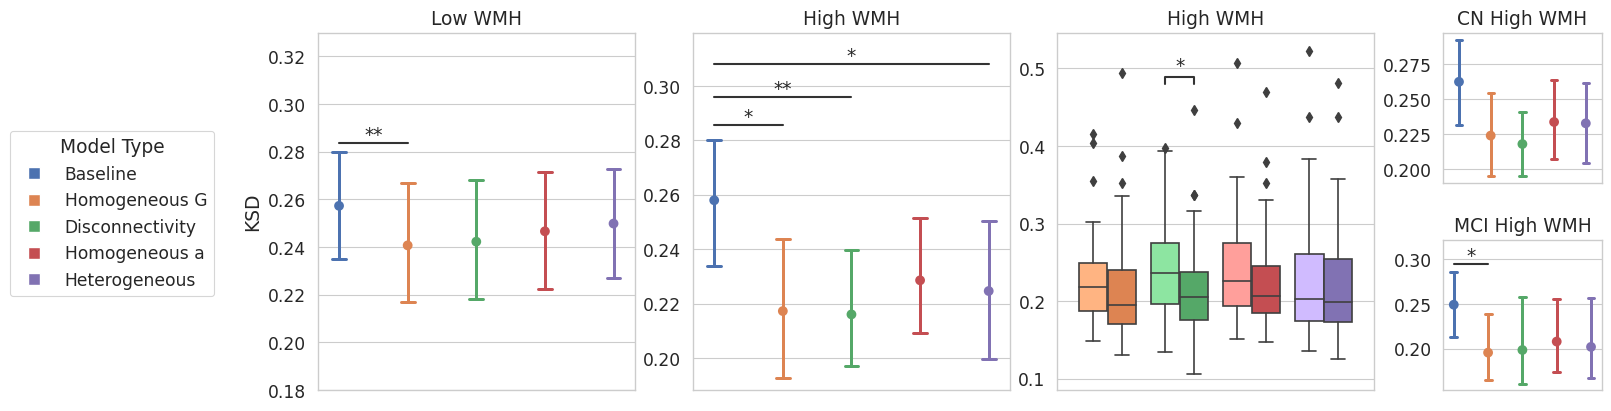

In [10]:
order = [
    "baseline",
    "homogeneous_G",
    "disconnectivity",
    "homogeneous_a",
    "heterogeneous",
]
order_rand = [
    "homogeneous_G",
    "disconnectivity",
    "homogeneous_a",
    "heterogeneous",
]
model_types = [
    "Baseline",
    "Homogeneous G",
    "Disconnectivity",
    "Homogeneous a",
    "Heterogeneous",
]
colors = sns.color_palette("deep", n_colors=len(model_types))

sns.set_style("whitegrid")
with sns.plotting_context("paper", font_scale=1.4):
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    axs = fig.subplot_mosaic(
        [["Left", "CenterLeft", "CenterRight", "TopRight"], ["Left", "CenterLeft", "CenterRight", "BottomRight"]],
        gridspec_kw={"width_ratios": [1, 1, 1, 0.5]},
    )

    plot_obs(df_model_comparison_low_wmh_long, "low_wmh", "avg", "phfcd_ks", axs["Left"])
    plot_obs(df_model_comparison_high_wmh_long, "high_wmh", "avg", "phfcd_ks", axs["CenterLeft"])
    plot_random_comparison(df_model_rand_vs_non_rand, axs["CenterRight"], order_rand)
    plot_obs(df_model_comparison_high_wmh_cn_long, "high_wmh_cn", "avg", "phfcd_ks", axs["TopRight"])
    plot_obs(df_model_comparison_high_wmh_mci_long, "high_wmh_mci", "avg", "phfcd_ks", axs["BottomRight"])
    

    axs["Left"].set_title("Low WMH")
    axs["Left"].set_ylim(0.18, 0.33)
    axs["Left"].set_ylabel("KSD")
    axs["Left"].set_xticklabels("")
    axs["Left"].set_xlabel("")

    axs["CenterLeft"].set_title("High WMH")
    axs["CenterLeft"].set_ylabel("")
    axs["CenterLeft"].set_xticklabels("")
    axs["CenterLeft"].set_xlabel("")

    axs["CenterRight"].set_title("High WMH")
    axs["CenterRight"].set_ylabel("")
    axs["CenterRight"].set_xticklabels("")
    axs["CenterRight"].set_xlabel("")

    axs["TopRight"].set_title("CN High WMH")
    axs["TopRight"].set_ylabel("")
    axs["TopRight"].set_xticklabels("")
    axs["TopRight"].set_xlabel("")

    axs["BottomRight"].set_title("MCI High WMH")
    axs["BottomRight"].set_ylabel("")
    axs["BottomRight"].set_xticklabels("")
    axs["BottomRight"].set_xlabel("")

    update_boxplot_color(axs["CenterRight"])
    
    # Create a legend with model types and colors
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="s",
            color="w",
            label=model_type,
            markerfacecolor=color,
            markersize=8,
        )
        for model_type, color in zip(model_types, colors)
    ]
    axs["Left"].legend(handles=legend_elements, title="Model Type", bbox_to_anchor=(-.3, .75))

    # fig.tight_layout()

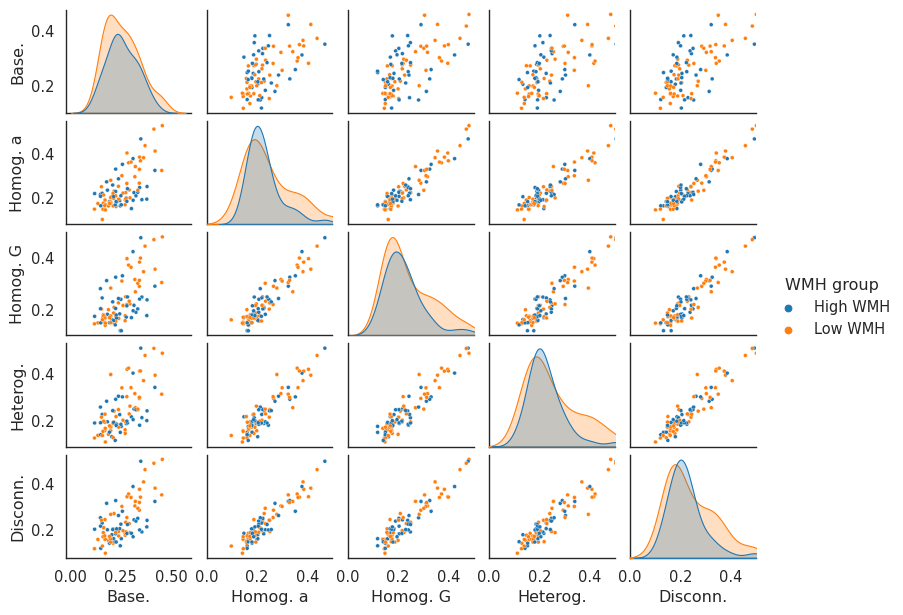

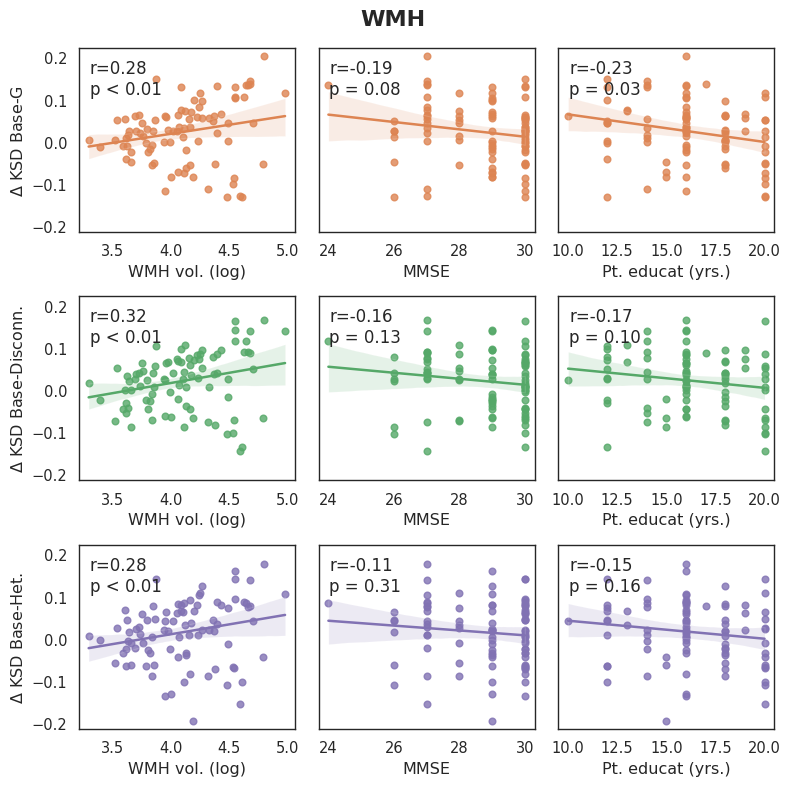

In [47]:
df_model_diffs, df_model_diffs_wide = calculate_model_diffs(df_model_comparison_wmh_wide, is_random=False)
df_model_diffs = pd.merge(df_model_diffs_wide, df_petTOAD[["PTID", "wmh_log", "MMSE", "PTEDUCAT"]], on = "PTID")

with sns.plotting_context("paper", font_scale = 1.2):

    fig, axs = plt.subplots(3, 3, figsize = (8, 8), sharey=True)
    
    sns.regplot(data= df_model_diffs, x = "wmh_log", y = "phfcd_ks_diff_base_G", ax = axs[0, 0], color=sns.color_palette("deep")[1])
    sns.regplot(data= df_model_diffs, x = "MMSE", y = "phfcd_ks_diff_base_G", ax = axs[0, 1], color=sns.color_palette("deep")[1])
    sns.regplot(data= df_model_diffs, x = "PTEDUCAT", y = "phfcd_ks_diff_base_G", ax = axs[0, 2], color=sns.color_palette("deep")[1])
    
    sns.regplot(data= df_model_diffs, x = "wmh_log", y = "phfcd_ks_diff_base_disconn", ax = axs[1, 0], color=sns.color_palette("deep")[2])
    sns.regplot(data= df_model_diffs, x = "MMSE", y = "phfcd_ks_diff_base_disconn", ax = axs[1, 1], color=sns.color_palette("deep")[2])
    sns.regplot(data= df_model_diffs, x = "PTEDUCAT", y = "phfcd_ks_diff_base_disconn", ax = axs[1, 2], color=sns.color_palette("deep")[2])

    sns.regplot(data= df_model_diffs, x = "wmh_log", y = "phfcd_ks_diff_base_het", ax = axs[2, 0], color=sns.color_palette("deep")[4])
    sns.regplot(data= df_model_diffs, x = "MMSE", y = "phfcd_ks_diff_base_het", ax = axs[2, 1], color=sns.color_palette("deep")[4])
    sns.regplot(data= df_model_diffs, x = "PTEDUCAT", y = "phfcd_ks_diff_base_het", ax = axs[2, 2], color=sns.color_palette("deep")[4])

    axs[0, 0].set_ylabel(r"$\Delta$ KSD Base-G")
    axs[0, 1].set_ylabel("")
    axs[0, 2].set_ylabel("")
    
    axs[1, 0].set_ylabel(r"$\Delta$ KSD Base-Disconn.")
    axs[1, 1].set_ylabel("")
    axs[1, 2].set_ylabel("")
    
    axs[2, 0].set_ylabel(r"$\Delta$ KSD Base-Het.")
    axs[2, 1].set_ylabel("")
    axs[2, 2].set_ylabel("")
    
    axs[0, 0].set_xlabel("WMH vol. (log)")
    axs[1, 0].set_xlabel("WMH vol. (log)")
    axs[2, 0].set_xlabel("WMH vol. (log)")

    axs[0, 2].set_xlabel("Pt. educat (yrs.)")
    axs[1, 2].set_xlabel("Pt. educat (yrs.)")
    axs[2, 2].set_xlabel("Pt. educat (yrs.)")

    write_corr_pval(df_model_diffs, "wmh_log", "phfcd_ks_diff_base_G", axs[0, 0])
    write_corr_pval(df_model_diffs, "MMSE", "phfcd_ks_diff_base_G", axs[0, 1])
    write_corr_pval(df_model_diffs, "PTEDUCAT", "phfcd_ks_diff_base_G", axs[0, 2])

    write_corr_pval(df_model_diffs, "wmh_log", "phfcd_ks_diff_base_disconn", axs[1, 0])
    write_corr_pval(df_model_diffs, "MMSE", "phfcd_ks_diff_base_disconn", axs[1, 1])
    write_corr_pval(df_model_diffs, "PTEDUCAT", "phfcd_ks_diff_base_disconn", axs[1, 2])

    write_corr_pval(df_model_diffs, "wmh_log", "phfcd_ks_diff_base_het", axs[2, 0])
    write_corr_pval(df_model_diffs, "MMSE", "phfcd_ks_diff_base_het", axs[2, 1])
    write_corr_pval(df_model_diffs, "PTEDUCAT", "phfcd_ks_diff_base_het", axs[2, 2])
    
    fig.suptitle("WMH", fontweight="bold", fontsize=16)
    fig.tight_layout()

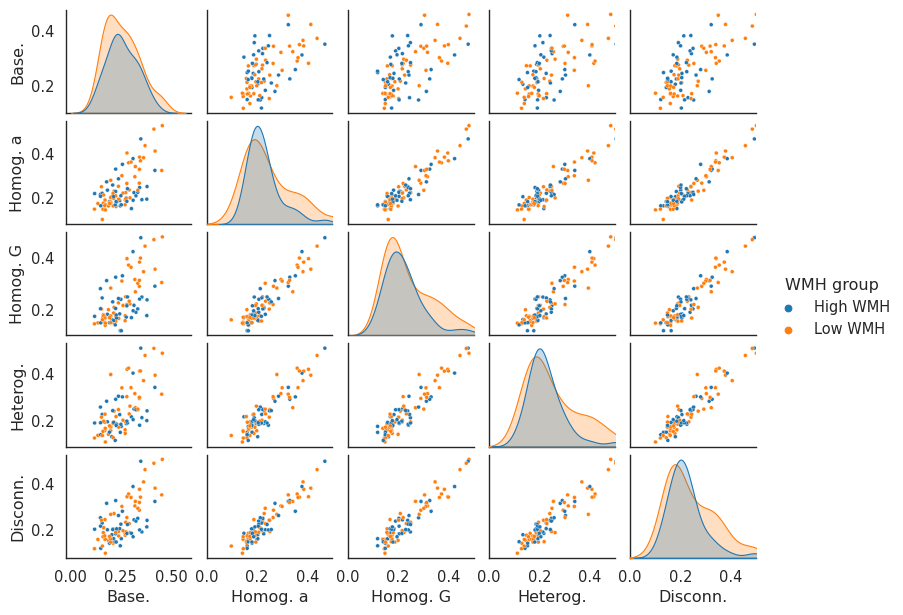

In [53]:
labels=["Base.","Homog. a", "Homog. G", "Heterog.", "Disconn."]
legend_labels = ["High WMH", "Low WMH"]
cols_to_keep = ["PTID", "phfcd_ks_baseline", "phfcd_ks_homogeneous_a", "phfcd_ks_homogeneous_G", "phfcd_ks_heterogeneous", "phfcd_ks_disconnectivity"]
df_model_comparison_wmh_wide_pairplot = pd.merge(df_model_comparison_wmh_wide[cols_to_keep], df_petTOAD[["PTID", "high_wmh_bin"]], on = "PTID")

sns.set_style("white")

with sns.plotting_context("paper", font_scale=1.2):
    p =sns.pairplot(df_model_comparison_wmh_wide_pairplot, hue="high_wmh_bin", height = 1.25, aspect=1.25, plot_kws={"s": 8})
    for ax, lbl in zip(p.axes.flatten(), labels):
        xlab = ax.get_xlabel()
        if len(xlab)==0: continue
        ax.set_xlim(0, 0.5)
        
        ylab = ax.get_ylabel()
        if len(ylab)==0: continue
        ax.set_xlim(0.0, 0.50),

    # Iterate over each subplot and set x and y-axis labels
    for i, lbl in enumerate(labels):
        # Set x-axis label
        p.axes[-1][i].set_xlabel(lbl)
        # Set y-axis label
        p.axes[i][0].set_ylabel(lbl)
    

    # Get the current legend
    legend = p._legend
    # Update the legend labels
    for t, l in zip(legend.texts, legend_labels):
        t.set_text(l)
    legend.set_title("WMH group")
